# Two pass alignment StringTie2 transcript assembly benchmarks

In this notebook we generate figures to benchmark transcript assembly after two pass alignment

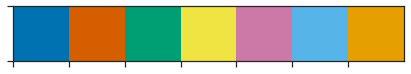

In [1]:
import sys
import os
import re
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [31]:
USESAMPLES = [
    'firstpass', 'nofilt', 'dt1filt', 'dt2filt', 'flair_corrected', 'refguided'
]

def parse_gffcompare_stats(stats_fn):
    pr = pd.read_csv(
        stats_fn,
        sep='[:\s|]{2,}',
        engine='python',
        skiprows=10,
        nrows=6,
        usecols=[0, 1, 2],
        header=None
    )
    pr.columns = ['level', 'recall', 'precision']

    counts = pd.read_csv(
        stats_fn,
        sep='[:\s|]{2,}',
        engine='python',
        skiprows=17,
        nrows=3,
        usecols=[0, 1, 2],
        header=None,
    )
    counts.columns = ['feature_level', 'counts']
    counts = counts.set_index('feature_level').counts

    other_stats = pd.read_csv(
        stats_fn,
        sep='[:\s|)(/%]+',
        engine='python',
        skiprows=20,
        nrows=6,
        usecols=[0, 1, 2, 3, 4],
        header=None
    )
    other_stats.columns = ['cat', 'feature', 'identified', 'total', 'percentage']

    return pr, counts, other_stats


def get_sim_stringtie_res(basename, usesamples=USESAMPLES):
    stringtie_res = {}
    for fn in glob(f'../{basename}/*/assemblies/*.sim_nofrag.*.stats'):
        sample_name, sample_type = re.search('assemblies/(.+?)\.sim_nofrag\.(.+?)\.stats$', fn).groups()
        p, _, _ = parse_gffcompare_stats(fn)
        stringtie_res[(sample_name, sample_type)] = p.loc[p.level == 'Intron chain level', ['precision', 'recall']]
    stringtie_res = pd.concat(
        stringtie_res,
        axis=0,
        names=['dataset', 'method']
    ).reset_index()[['dataset', 'method', 'precision', 'recall']]
    stringtie_res['f1_score'] = stats.hmean([stringtie_res.precision / 100, stringtie_res.recall / 100], axis=0)
    return stringtie_res

In [32]:
arath_stringtie_res = get_sim_stringtie_res('arabidopsis_drs')
human_stringtie_res = get_sim_stringtie_res('human_drs')

In [34]:
arath_stringtie_res.groupby('method').f1_score.median()

method
dt1filt           0.729609
dt2filt           0.734394
dt2filt_merged    0.742866
dtfilt            0.731173
ensfilt           0.733633
ensfilt2          0.733574
firstpass         0.662230
jadfilt           0.727068
nofilt            0.700427
refguided         0.775406
seqfilt           0.724367
seqfilt2          0.726775
Name: f1_score, dtype: float64

In [41]:
dt2_vs_fp_prec = arath_stringtie_res[arath_stringtie_res.method.isin(['firstpass', 'dt2filt'])].pivot(
    index='dataset', columns='method', values='precision'
)
dt2_vs_fp_prec.dt2filt - dt2_vs_fp_prec.firstpass

dataset
201901_col0_2916    20.2
201901_col0_2917    16.6
201901_col0_2918    14.5
201901_col0_2919    15.1
dtype: float64

In [42]:
dt2_vs_fp_prec = human_stringtie_res[human_stringtie_res.method.isin(['firstpass', 'dt2filt'])].pivot(
    index='dataset', columns='method', values='precision'
)
dt2_vs_fp_prec.dt2filt - dt2_vs_fp_prec.firstpass

dataset
20191112_human_bham1    25.0
20191112_human_bham2    19.5
20191112_human_bham3    21.5
20191112_human_bham5    23.2
dtype: float64

In [35]:
human_stringtie_res.groupby('method').f1_score.median()

method
dt1filt           0.585828
dt2filt           0.595395
dt2filt_merged    0.618714
ensfilt           0.604415
firstpass         0.485075
jadfilt           0.577975
nofilt            0.520736
refguided         0.675789
seqfilt           0.574372
Name: f1_score, dtype: float64

In [18]:
def plot_precision_recall(data, ax, plot=['firstpass', 'dt1filt', 'dt2filt', 'refguided']):
    for c, lab in zip(pal, plot):
        ax.scatter(x='recall', y='precision', data=data.query(f'method == "{lab}"'), c=[c,], label=lab)
    ax.set_xlabel('Recall (%)')
    ax.set_ylabel('Precision (%)')
    ax.legend()
    ax.legend_.remove()
    return ax

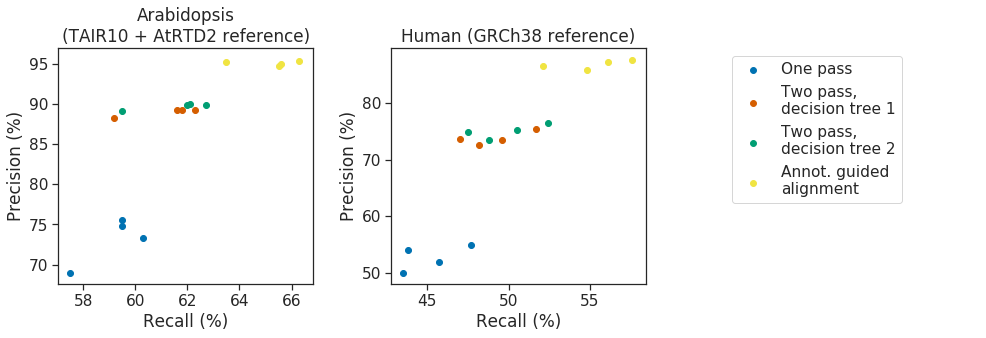

In [19]:
fig, axes = plt.subplots(figsize=(14, 5), ncols=3)

plot_precision_recall(arath_stringtie_res, axes[0])
plot_precision_recall(human_stringtie_res, axes[1])

axes[2].set_axis_off()

dhs = []
labels = [
    'One pass',
    'Two pass,\ndecision tree 1',
    'Two pass,\ndecision tree 2',
    'Annot. guided\nalignment'
]
for i, label in enumerate(labels):
    dh = axes[2].scatter([], [], color=pal[i], s=35)
    dhs.append(dh)

axes[2].legend_ = plt.legend(dhs, labels, loc=2)
axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
axes[1].set_title('Human (GRCh38 reference)')
plt.tight_layout()
plt.savefig('figures/simulated_data_stringtie_benchmark.svg')
plt.show()

In [43]:
DEFAULT_BOXPLOT_KWARGS = {'color': '#eeeeee', 'fliersize': 0, 'width': 0.8}
DEFAULT_STRIPPLOT_KWARGS = {'jitter': 0.2, 'color': pal[0], 'size': 8, 'dodge': True}


def boxplot_with_overlaid_stripplot(*, x, y, hue=None, data=None,
                                    order=None, strip_hue=None,
                                    boxplot_kwargs=None,
                                    stripplot_kwargs=None,
                                    ax=None):
    if boxplot_kwargs is None:
        boxplot_kwargs = DEFAULT_BOXPLOT_KWARGS
    else:
        boxplot_kwargs = dict(DEFAULT_BOXPLOT_KWARGS, **boxplot_kwargs)

    if stripplot_kwargs is None:
        stripplot_kwargs = DEFAULT_STRIPPLOT_KWARGS
    else:
        stripplot_kwargs = dict(DEFAULT_STRIPPLOT_KWARGS, **stripplot_kwargs)

    ax = sns.boxplot(
        x=x,
        y=y,
        data=data,
        hue=hue,
        order=order,
        ax=ax,
        **boxplot_kwargs
    )

    ax = sns.stripplot(
        x=x,
        y=y,
        data=data,
        hue=strip_hue if strip_hue is not None else hue,
        order=order,
        ax=ax,
        **stripplot_kwargs
    )

    return ax


def plot_precision_count_boxplots(data,
                                  plot=['firstpass', 'dt2filt', 'refguided'],
                                  labels=['One pass', 'Two pass', 'Ref. guided'],
                                  suptitle=''):
    fig, axes = plt.subplots(figsize=(6, 5), ncols=2)
    boxplot_with_overlaid_stripplot(
        x='method',
        y='intron_chains',
        strip_hue='dataset',
        data=data,
        order=plot,
        ax=axes[0],
        stripplot_kwargs={'color': None, 'palette': pal}
    )
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Annotated transcripts assembled')
    axes[0].legend_.remove()
    axes[0].set_xticklabels(labels, rotation=30, ha='right')
    boxplot_with_overlaid_stripplot(
        x='method',
        y='precision',
        strip_hue='dataset',
        data=data,
        order=plot,
        ax=axes[1],
        stripplot_kwargs={'color': None, 'palette': pal}
    )
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Precision (%)')
    axes[1].legend_.remove()
    axes[1].set_xticklabels(labels, rotation=30, ha='right')
    fig.suptitle(suptitle)
    plt.tight_layout()
    return axes


def plot_real_assembly_scores(basename, title):
    
    stringtie_res = []

    for fn in glob(f'../{basename}/*/assemblies/*.real.*.stats'):
        sample_name = re.search(f'{basename}/(.+?)/assemblies', fn).group(1)
        sample_type = re.search('real\.(.+?)\.stats$', fn).group(1)
        p, c, o = parse_gffcompare_stats(fn)
        stringtie_res.append([
            sample_name, sample_type,
            float(p.loc[p.level == 'Intron chain level', 'precision']),
            float(p.loc[p.level == 'Intron chain level', 'recall']),
            float(c.loc['Matching intron chains'])
        ])

    stringtie_res = pd.DataFrame(
        stringtie_res,
        columns=['dataset', 'method', 'precision', 'recall', 'intron_chains']
    )
    axes = plot_precision_count_boxplots(stringtie_res, suptitle=title)
    return axes, stringtie_res

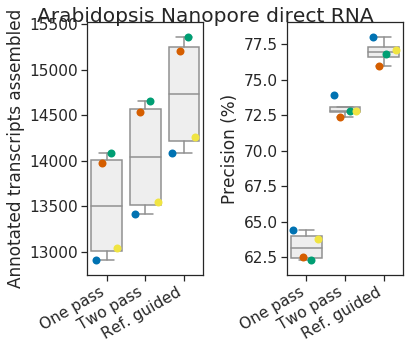

In [21]:
plot_real_assembly_scores('arabidopsis_drs', 'Arabidopsis Nanopore direct RNA')
plt.savefig('figures/arabidopsis_drs_stringtie_benchmark.svg')
plt.show()

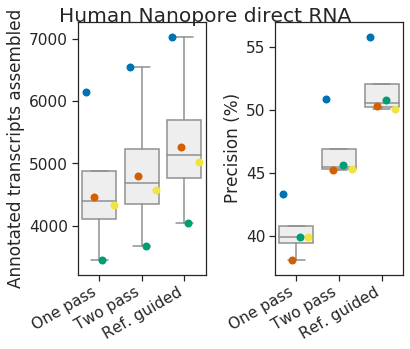

In [22]:
plot_real_assembly_scores('human_drs', 'Human Nanopore direct RNA')
plt.savefig('figures/human_drs_stringtie_benchmark.svg')
plt.show()

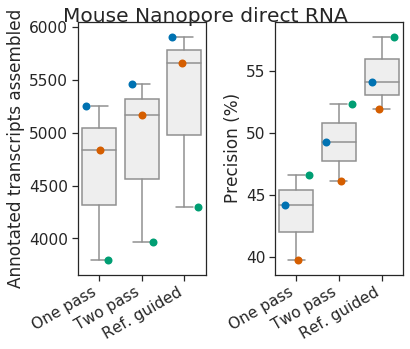

In [23]:
plot_real_assembly_scores('mouse_drs', 'Mouse Nanopore direct RNA')
plt.savefig('figures/mouse_drs_stringtie_benchmark.svg')
plt.show()

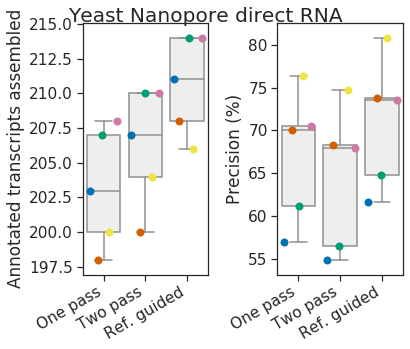

In [44]:
_, yeast_drs = plot_real_assembly_scores('yeast_drs', 'Yeast Nanopore direct RNA')
plt.savefig('figures/yeast_drs_stringtie_benchmark.svg')
plt.show()

In [50]:
yeast_prec_improvement = yeast_drs[yeast_drs.method.isin(['firstpass', 'refguided'])].pivot(
    index='dataset', columns='method', values='precision'
)
yeast_prec_improvement.refguided - yeast_prec_improvement.firstpass

dataset
garalde_ONT_yeast_rep0    4.5
garalde_ONT_yeast_rep1    4.7
garalde_ONT_yeast_rep2    3.8
garalde_ONT_yeast_rep3    3.6
garalde_ONT_yeast_rep4    3.0
dtype: float64

In [54]:
yeast_rec_improvement = yeast_drs[yeast_drs.method.isin(['firstpass', 'refguided'])].pivot(
    index='dataset', columns='method', values='intron_chains'
)
yeast_rec_improvement.refguided - yeast_rec_improvement.firstpass

dataset
garalde_ONT_yeast_rep0     6.0
garalde_ONT_yeast_rep1     8.0
garalde_ONT_yeast_rep2    10.0
garalde_ONT_yeast_rep3     7.0
garalde_ONT_yeast_rep4     6.0
dtype: float64

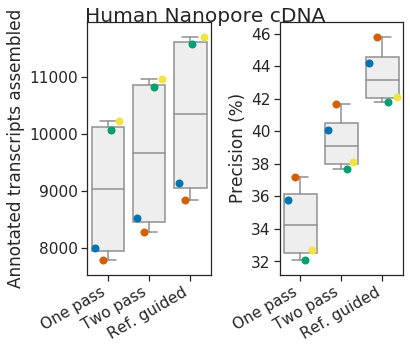

In [25]:
plot_real_assembly_scores('human_cdna', 'Human Nanopore cDNA')
plt.savefig('figures/human_cdna_stringtie_benchmark.svg')
plt.show()

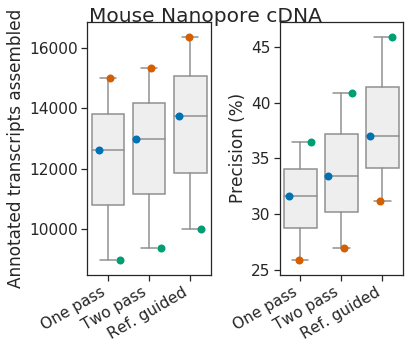

In [26]:
plot_real_assembly_scores('mouse_cdna', 'Mouse Nanopore cDNA')
plt.savefig('figures/mouse_cdna_stringtie_benchmark.svg')
plt.show()

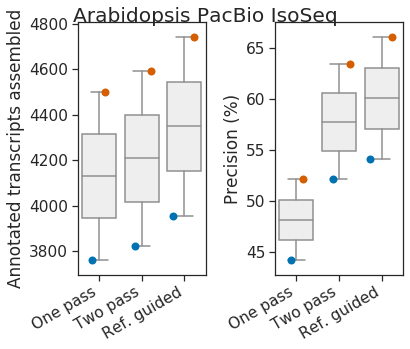

In [27]:
plot_real_assembly_scores('arabidopsis_isoseq', 'Arabidopsis PacBio IsoSeq')
plt.savefig('figures/arabidopsis_isoseq_stringtie_benchmark.svg')
plt.show()

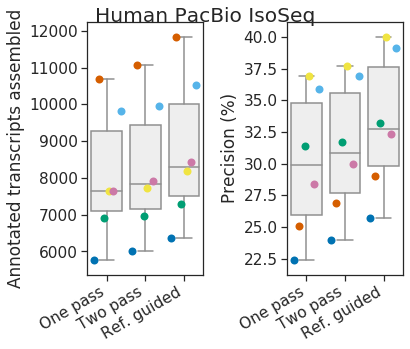

In [28]:
plot_real_assembly_scores('human_isoseq', 'Human PacBio IsoSeq')
plt.savefig('figures/human_isoseq_stringtie_benchmark.svg')
plt.show()